# Predicting Gender of Shughni Nouns Using Machine Learning Methods

## Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, json
from tqdm import tqdm

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.sparse import hstack

import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
import os

import warnings
warnings.filterwarnings("ignore")

## Data preparation

### Loading the data

In [2]:
data = pd.merge(
    pd.read_csv("res_subset_sem.csv"),
    pd.read_csv("res_subset_forms.csv").drop_duplicates(subset="unit_id", keep="first"),
    on="unit_id", how="left"
)

In [3]:
data.columns

Index(['meaning_id', 'unit_id', 'full_entry', 'meaning', 'article_gender',
       'meaning_gender', 'gendered', 'comment', 'suffix', 'suffix_bVc',
       'suffix_ak', 'deverbal', 'infinitive', 'russian_borrowing', 'stress',
       'human', 'sex=f', 'sex=m', 'indspec', 'massabstr', 'large', 'small',
       'animals', 'water', 'trees', 'fruit', 'techtransport', 'culturalprod.',
       'name', 'householdobjects', 'food', 'drink', 'plants', 'events', 'pos',
       'neg', 'weather', 'bodyparts', 'buildings', 'landscape', 'milkprod.',
       'sicknesses', 'meanings_concatenated', 'meaning_with_examples',
       'label_id', 'forms_id', 'gloss_id', 'gloss', 'form', 'source'],
      dtype='object')

In [4]:
data = data[(data["meaning_gender"].isin(["m", "f"])) & (~data["comment"].isin([
    "adjective", "fluid", "onomatopoeia", "name", "abstr human"
]))]
data["comment"] = data["comment"].astype("str")
#data["meaning_gender"] = pd.Categorical(data["meaning_gender"], ("f", "m"))

In [5]:
tuned_params = {}

y_pred = {}   # dictionary with predicted values from different features and models
results = {}  # classification reports from different features and models
models = {}   # models used in predictions from different features (necessary to show feature importances)

In [6]:
word_endings = {}
x_feature_values = {}

### Extracting the features

In [7]:
sem_features = [#"human",
                "sex=f", "sex=m",
                "indspec", "massabstr", "large", "small",
                "animals", "water", "trees", "fruit", "techtransport", "culturalprod.",
                "householdobjects", "food", "drink", "plants", "events", "pos", "neg",
                "weather", "bodyparts", "buildings", "landscape", "milkprod.", "sicknesses"]

morph_features = ["suffix_ak", "suffix_bVc", "deverbal", "infinitive"]

#for sem_feature in sem_features:
#    data[sem_feature] = pd.Categorical(data[sem_feature], (0, 1))

vowels = ("a", "ā", "e", "ê", "i", "ī", "o", "u", "ū", "ů")

bad_letters = [("x̌", "X"), ("ɣ̌", "G"), ("ǰ", "j")]

In [8]:
def extract_n_letters(word, n):
    for pair in bad_letters:
        word = re.sub(pair[0], pair[1], word)
    
    if len(word)<n:
        return ""
    
    suffix = ""
    for i in range(len(word)-1, len(word)-n-1, -1):
        if word[i] == "-":
            return ""
        suffix = word[i] + suffix

    for pair in bad_letters:
        suffix = re.sub(pair[1], pair[0], suffix)
    return suffix


def last_vowel(word):
    for i in range(len(word)-1, -1, -1):
        if word[i] in vowels:
            return word[i]
    return None

In [9]:
for n in range(2, 5):
    data[f"last_{n}"] = data["form"].apply(lambda x: extract_n_letters(x, n))

data["last_vowel"] = data["form"].apply(lambda x: last_vowel(x))
#data["last_vowel"] = pd.Categorical(data["last_vowel"], vowels)

In [10]:
data.head(5)
#data.to_csv("res_subset_forms_suffixes.csv")

,meaning_id,unit_id,full_entry,meaning,article_gender,meaning_gender,gendered,comment,suffix,suffix_bVc,...,label_id,forms_id,gloss_id,gloss,form,source,last_2,last_3,last_4,last_vowel
0,1960,1275,"ш. АНȤЕМ(АК), б. ИНȤЕМ(АК) ж. годовалая овечка...","годовалая овечка, ярка",f,f,0,animal,(ak),0,...,NaN,4862,20,word,anʒem,2,em,ʒem,nʒem,e
1,2065,1352,шх. АРΔӮНҶ(АК) 2 ж. мельничный ковш (из которо...,мельничный ковш (из которого зерно высыпается ...,f,f,0,nan,(ak),0,...,NaN,5004,20,word,arδūnǰak,2,ak,ǰak,nǰak,a
2,3073,2193,"шх. БĀҶИБ, БАҶИБ, б. БĀҶИБ(АК) ж. 1) шх. дерев...",деревянная черпачка для муки; лопаточка,f,f,0,nan,(ak),0,...,11.0,6178,20,word,bāǰib,2,ib,ǰib,āǰib,i
3,3881,2897,БОБШИҚАРθЕНЦ(АК) 1) ж. червь (величиной с мизи...,червь (величиной с мизинец),f,f,0,animal,(ak),0,...,NaN,7096,20,word,bobšiqarθencak,2,ak,cak,ncak,a
4,3882,2897,БОБШИҚАРθЕНЦ(АК) 1) ж. червь (величиной с мизи...,мизинец,f,f,0,nan,(ak),0,...,NaN,7096,20,word,bobšiqarθencak,2,ak,cak,ncak,a


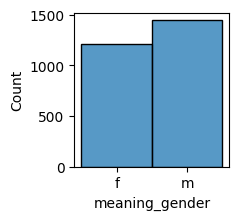

In [11]:
plt.figure(figsize=(2, 2))
sns.histplot(data["meaning_gender"])
plt.show()

### Exploring the features

#### Last vowel

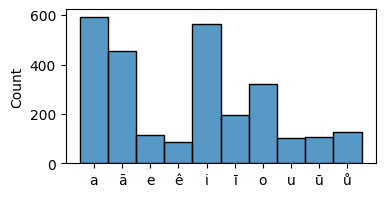

In [12]:
plt.figure(figsize=(4, 2))
sns.histplot(pd.Categorical(data["last_vowel"], vowels))
plt.show()

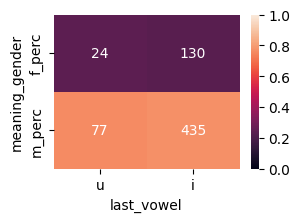

In [15]:
vowel_gender = data.groupby(by=["last_vowel", "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
vowel_gender["f_perc"] = round(vowel_gender["f"] / (vowel_gender["f"] + vowel_gender["m"]), 2)
vowel_gender["m_perc"] = round(vowel_gender["m"] / (vowel_gender["f"] + vowel_gender["m"]), 2)
vowel_gender = vowel_gender[(vowel_gender["m_perc"]<0.4) | (vowel_gender["f_perc"]<0.4)].sort_values("f_perc", ascending=False)

plt.figure(figsize=(3, 2))
sns.heatmap(vowel_gender[["f_perc", "m_perc"]].T, annot=vowel_gender[["f", "m"]].T, fmt="g", vmin=0, vmax=1)
plt.savefig("last_vowel by gender.png", bbox_inches='tight')
plt.show()

#### Last N

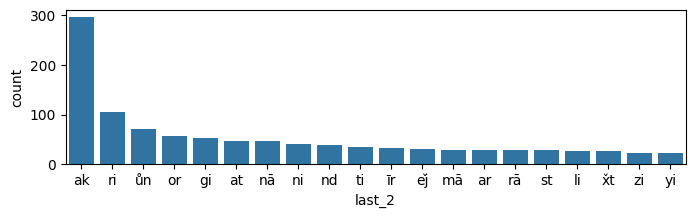

In [18]:
plt.figure(figsize=(8, 2))
popular_endings = data["last_2"].value_counts()[:20]
popular_endings = popular_endings[popular_endings>20]
sns.barplot(popular_endings)
plt.show()

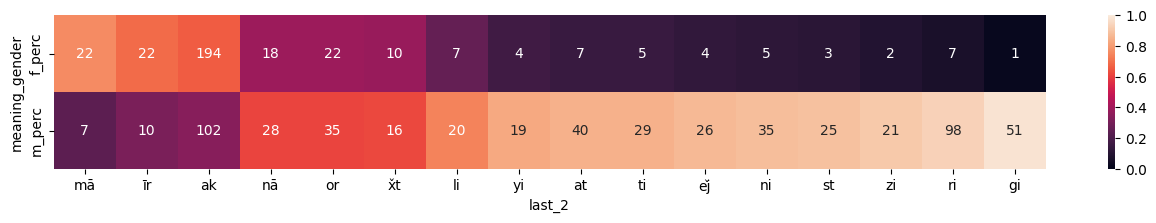

In [19]:
last_gender = data[data["last_2"].isin(popular_endings.keys())].groupby(by=["last_2", "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
last_gender["f_perc"] = round(last_gender["f"] / (last_gender["f"] + last_gender["m"]), 2)
last_gender["m_perc"] = round(last_gender["m"] / (last_gender["f"] + last_gender["m"]), 2)
last_gender = last_gender[(last_gender["m_perc"]<0.4) | (last_gender["f_perc"]<0.4)].sort_values("f_perc", ascending=False)

plt.figure(figsize=(16, 2))
sns.heatmap(last_gender[["f_perc", "m_perc"]].T, annot=last_gender[["f", "m"]].T, fmt="g", vmin=0, vmax=1)
plt.savefig("last_2 by gender.png", bbox_inches='tight')
plt.show()

#### Semantic features

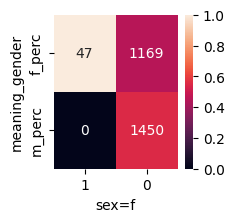

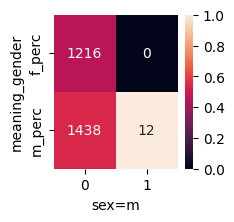

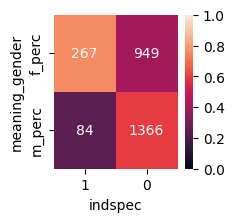

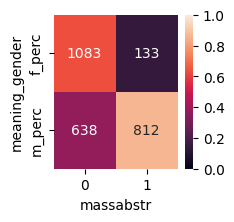

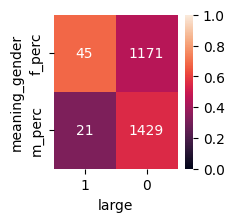

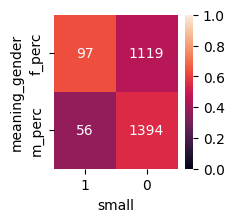

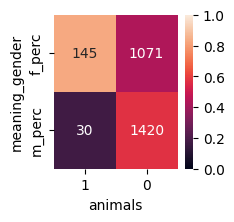

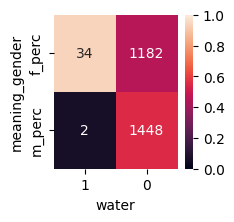

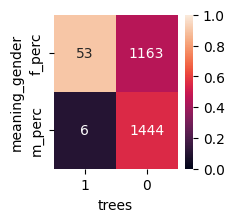

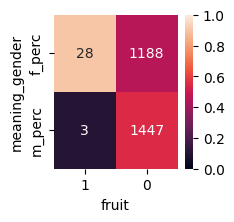

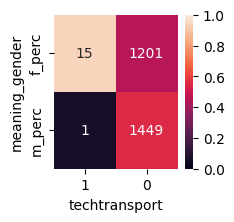

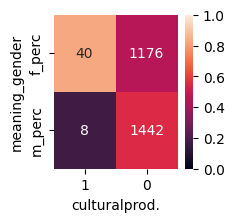

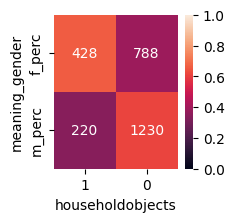

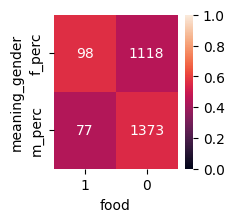

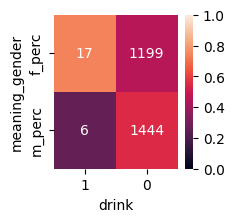

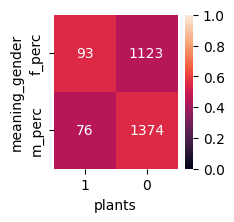

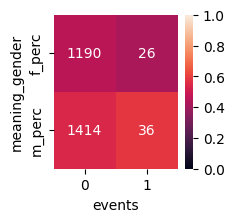

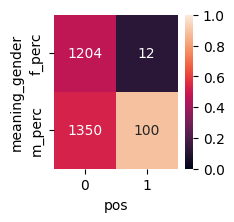

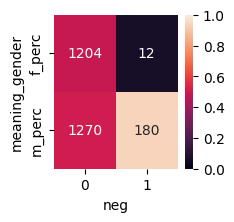

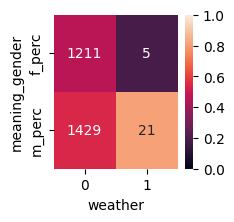

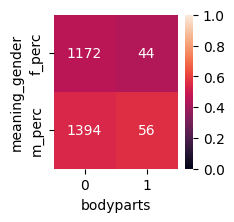

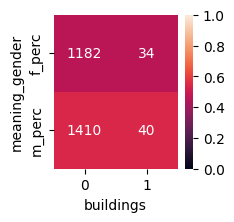

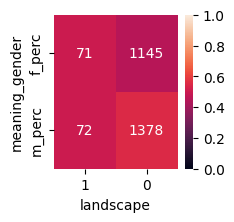

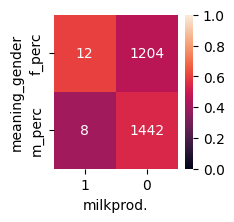

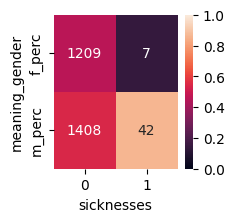

In [22]:
for sem_feature in sem_features:
    sem_gender = data.groupby(by=[sem_feature, "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
    sem_gender["f_perc"] = round(sem_gender["f"] / (sem_gender["f"] + sem_gender["m"]), 2)
    sem_gender["m_perc"] = round(sem_gender["m"] / (sem_gender["f"] + sem_gender["m"]), 2)
    sem_gender = sem_gender.sort_values("f_perc", ascending=False)
    
    plt.figure(figsize=(2, 2))
    sns.heatmap(sem_gender[["f_perc", "m_perc"]].T, annot=sem_gender[["f", "m"]].T, fmt="g", vmin=0, vmax=1)
    plt.savefig(f"{sem_feature} by gender.png", bbox_inches='tight')
    plt.show()

#### Morphological features

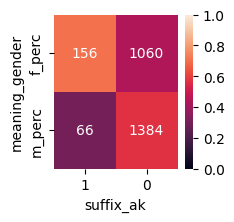

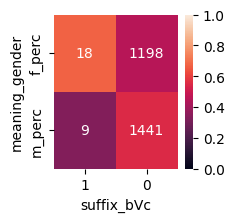

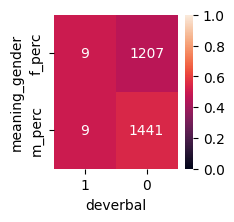

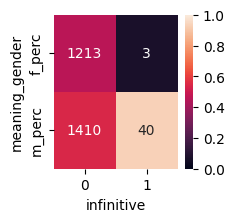

In [23]:
for morph_feature in morph_features:
    morph_gender = data.groupby(by=[morph_feature, "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
    morph_gender["f_perc"] = round(morph_gender["f"] / (morph_gender["f"] + morph_gender["m"]), 2)
    morph_gender["m_perc"] = round(morph_gender["m"] / (morph_gender["f"] + morph_gender["m"]), 2)
    morph_gender = morph_gender.sort_values("f_perc", ascending=False)
    
    plt.figure(figsize=(2, 2))
    sns.heatmap(morph_gender[["f_perc", "m_perc"]].T, annot=morph_gender[["f", "m"]].T, fmt="g", vmin=0, vmax=1)
    plt.savefig(f"{morph_feature} by gender.png", bbox_inches='tight')
    plt.show()

## Training preparation

### Training and transformation functions

In [11]:
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    _y_pred = model.predict(X_test)
    return _y_pred, classification_report(y_test, _y_pred, output_dict=True)


def train_models(X_train, y_train, settings):
    if not settings["MODELS_TO_TRAIN"]:
        settings["MODELS_TO_TRAIN"] = ("mnb", "rfc", "dtc", "log", "catb")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=settings["TEST_SIZE"],
        random_state=settings["RANDOM_STATE"]
    )
    _y_pred, _results, _models = {}, {}, {}
    
    if "mnb" in settings["MODELS_TO_TRAIN"]:
        _models["mnb"] = MultinomialNB(
            alpha=settings["MNB_ALPHA"], fit_prior=settings["MNB_FIT_PRIOR"]
        )
        _y_pred["MultinomialNB"], _results["MultinomialNB"] = fit_predict(
            _models["mnb"], X_train, y_train, X_test, y_test)
        _y_train_pred = _models["mnb"].predict(X_train)
        _results["MultinomialNB"]["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
    
    if "log" in settings["MODELS_TO_TRAIN"]:
        _models["log"] = LogisticRegression(
            penalty=settings["LOG_PENALTY"],
            C=settings["LOG_C"],
            solver=settings["LOG_SOLVER"]
        )
        _y_pred["LogisticRegression"], _results["LogisticRegression"] = fit_predict(
            _models["log"], X_train, y_train, X_test, y_test)
        _y_train_pred = _models["log"].predict(X_train)
        _results["LogisticRegression"]["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
    
    if "rfc" in settings["MODELS_TO_TRAIN"]:
        _models["rfc"] = RandomForestClassifier(
            max_depth=settings["RFC_MAX_DEPTH"],
            min_samples_leaf=settings["RFC_MIN_SAMPLES_LEAF"]
        )
        _y_pred["RandomForestClassifier"], _results["RandomForestClassifier"] = fit_predict(
            _models["rfc"], X_train, y_train, X_test, y_test)
        _results["RandomForestClassifier"]["accuracy_train"] = _models["rfc"].score(X_train, y_train)
    
    if "dtc" in settings["MODELS_TO_TRAIN"]:
        _models["dtc"] = DecisionTreeClassifier(
            max_depth=settings["DTC_MAX_DEPTH"],
            min_samples_leaf=settings["DTC_MIN_SAMPLES_LEAF"]
        )
        _y_pred["DecisionTreeClassifier"], _results["DecisionTreeClassifier"] = fit_predict(
            _models["dtc"], X_train, y_train, X_test, y_test)
        _results["DecisionTreeClassifier"]["accuracy_train"] = _models["dtc"].score(X_train, y_train)

    if "catb" in settings["MODELS_TO_TRAIN"]:
        _models["catb"] = CatBoostClassifier(
            iterations=settings["CATB_ITERATIONS"],
            learning_rate=settings["CATB_LEARNING_RATE"],
            depth=settings["CATB_DEPTH"],
            silent=True
        )
        _y_pred["CatBoostClassifier"], _results["CatBoostClassifier"] = fit_predict(
            _models["catb"], X_train, y_train, X_test, y_test)
        _results["CatBoostClassifier"]["accuracy_train"] = _models["catb"].score(X_train, y_train)

    return _y_pred, _results, _models


def show_accuracy(results):
    return {key: round(results[key]["accuracy"], 4) for key in results.keys()}


def show_class_score(results, score_name):
    class_score = {}
    for key in results.keys():
        class_score[key] = {}
        for class_ in ("f", "m"):
            class_score[key][class_] = round(results[key][class_][score_name], 4) 
    return class_score


def show_overfitting(results, model):
    accs = {}
    accs["accuracy_test"] = round(results[model]["accuracy"], 4)
    if "accuracy_train" in results[model]:
        accs["accuracy_train"] = round(results[model]["accuracy_train"], 4)
    return accs


def show_importances(model, features, n=20):
    indices = np.argsort(model.feature_importances_)[::-1]
    importances = []
    for f in range(min(n, len(features))):
        importances.append({
            "feature": features[indices[f]],
            "importance": model.feature_importances_[indices[f]]
        })
    return pd.DataFrame(importances, index=range(1, min(n, len(features))+1))


def dtc_tree(model, feature_names):
    plt.figure(figsize=(40, 20))
    plot_tree(model, filled=True, feature_names=feature_names,
          class_names=True, impurity=False, label="none", fontsize=16)
    plt.show()


def transform_VECTORIZER(feature):
    return CountVectorizer().fit_transform(data[feature])


def transform_OHE(feature):
    ohe = OneHotEncoder()
    return ohe.fit_transform(data[[feature]]), ohe.get_feature_names_out()


model_path = 'fasttext_wiki_news_subwords_300.kv'


def load_fasttext_model():
    if os.path.exists(model_path):
        model = KeyedVectors.load(model_path)  
    else:
        model = api.load("fasttext-wiki-news-subwords-300")
        model.save(model_path)  
    return model

def transform_FASTTEXT(feature): 
    
    model = load_fasttext_model()
    
    def vectorize_text(text):
        words = simple_preprocess(text, deacc=True)
        word_vectors = [model[word] for word in words if word in model]
        if not word_vectors:
            return np.zeros(model.vector_size)
        return np.mean(word_vectors, axis=0)
    return np.array([vectorize_text(text) for text in data[feature]])


def transform_x_values(_x_feature_values, _word_endings):
    for _FEATURE in ("meaning",):
        _x_feature_values[_FEATURE] = transform_VECTORIZER(_FEATURE)
    for _FEATURE in ("meaning_with_examples",):
        _x_feature_values["meaning_with_examples_vec"] = transform_VECTORIZER(_FEATURE)
    #for _FEATURE in ("meaning_with_examples",):
    #    _x_feature_values["meaning_with_examples_pretrained"] = transform_FASTTEXT(_FEATURE)
    for _FEATURE in ("last_vowel",):
        _x_feature_values[_FEATURE], _vowels_feature_names = transform_OHE(_FEATURE)
    for _FEATURE in ("last_2", "last_3", "last_4"):
        _x_feature_values[_FEATURE], _word_endings[_FEATURE] = transform_OHE(_FEATURE)
    return _x_feature_values, _vowels_feature_names, _word_endings


def stack_x(features_):
    features_ = features_.split(" + ")
    features_ = [x_feature_values[f] for f in features_]
    try:
        hst = hstack(features_)
    except ValueError:
        hst = np.column_stack(features_)
    return hst

### Transforming _x_-values

In [12]:
x_feature_values, vowels_feature_names, word_endings = transform_x_values(x_feature_values, word_endings)
x_feature_values["sem_features"] = data[sem_features]
x_feature_values["morph_features"] = data[morph_features]

### Fine-tuning

In [ ]:
def grid_search(model_, params_, X_train, X_test, y_train, y_test):
    gs = GridSearchCV(model_, params_, cv=5, scoring='f1_weighted')
    gs.fit(X_train, y_train)

    print("Best parameters:", gs.best_params_)
    #print("Best score (f1 weighted):", round(gs.best_score_, 3))

    best_model = gs.best_estimator_
    f1_weighted = f1_score(y_test, best_model.predict(X_test), average='weighted')
    print("Test F1-Weighted:", round(f1_weighted, 3), "\n")

    return best_model, gs.best_params_

In [ ]:
params_to_tune = {
    "dtc": {
        'max_depth': [5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 5, 10]},
    "rfc": {
        'max_depth': [5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 5, 10]},
    "mnb": {
        'alpha': [0, 0.5, 1, 2, 5],
        'fit_prior': [True, False]},
    "log": {
        'penalty': ["l1", "l2"],
        'C': [0, 0.5, 1, 1.5, 2],
        'solver': ["liblinear"]}
}

def find_best_params(model_name, feature):
    params_ = params_to_tune[model_name]
    if model_name == "dtc":
        model_ = DecisionTreeClassifier()
    elif model_name == "rfc":
        model_ = RandomForestClassifier()
    elif model_name == "mnb":
        model_ = MultinomialNB()
    elif model_name == "log":
        model_ = LogisticRegression()

    print(f"Feature: {feature} === Model: {model_}")
    
    return grid_search(model_, params_, *train_test_split(
        x_feature_values[feature], data["meaning_gender"],
        test_size=SETTINGS["TEST_SIZE"], random_state=SETTINGS["RANDOM_STATE"]))

In [ ]:
SETTINGS = {
    "RANDOM_STATE": 42,
    "TEST_SIZE": 0.2,
    "MODELS_TO_TRAIN": ["mnb", "rfc", "dtc", "log",]
}

In [ ]:
tune_features = ("last_vowel", "last_2", "meaning", "sem_features")

for feature in tune_features:
    models[feature] = {}
    tuned_params[feature] = {}
    for model in SETTINGS["MODELS_TO_TRAIN"]:
        models[feature][model], tuned_params[feature][model] = find_best_params(model, feature)

## Training

In [18]:
SETTINGS = {
    "RANDOM_STATE": 42,
    "TEST_SIZE": 0.2,
                                # ↓ default 
    "DTC_MAX_DEPTH": 50,        #   None
    "DTC_MIN_SAMPLES_LEAF": 3,  #   1
    "RFC_MAX_DEPTH": 50,        #   None
    "RFC_MIN_SAMPLES_LEAF": 3,  #   1
    "MNB_ALPHA": 1.0,           #   1.0
    "MNB_FIT_PRIOR": True,      #   True
    "LOG_PENALTY": "l2",        #   l2
    "LOG_C": 1.0,               #   1.0
    "LOG_SOLVER": "lbfgs",      #   lbfgs
    "CATB_ITERATIONS": None,    #   None   100
    "CATB_LEARNING_RATE": None, #   None   0.1
    "CATB_DEPTH": None,         #   None   6

    "MODELS_TO_TRAIN": ["mnb", "log", "rfc", "dtc", "catb"]
}

# hyperparameters were picked using GridSearchCV
# out of all tested options which test score to train score was <= 5%
# the parameters with the highest test score were chosen

In [19]:
for FEATURE in tqdm(["last_vowel",
                     "morph_features",
                     "last_2", "last_3",
                     "meaning",
                     "sem_features"
                    #"meaning_with_examples_vec",
                    #"meaning_with_examples_pretrained",
                    ]):
    y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
        x_feature_values[FEATURE], data["meaning_gender"], SETTINGS)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:26<00:00, 14.42s/it]


In [20]:
stacked_features = (
    "last_2 + last_3",
    "last_2 + last_3 + last_vowel + morph_features",
    
    "sem_features + last_vowel",
    "sem_features + morph_features",
    "sem_features + last_2",
    "sem_features + last_3",
    "sem_features + last_2 + last_3 + morph_features",
    
    "sem_features + meaning",
    "sem_features + meaning + morph_features",
    #"sem_features + last_vowel + meaning_with_examples_vec",
    "sem_features + meaning + last_2",
    "sem_features + meaning + last_3",
    "sem_features + meaning + last_2 + last_3 + morph_features",
)

for FEATURE in tqdm(stacked_features):
    y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
        stack_x(FEATURE), data["meaning_gender"], SETTINGS)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:05<00:00, 25.47s/it]


## Analysis

### Overfitting

In [ ]:
overfitting_log = {}
for key in results:
    overfitting_log[key] = show_overfitting(results[key], "LogisticRegression")
overfitting_log = pd.DataFrame(overfitting_log).transpose()

plt.figure(figsize=(4, 9))
sns.heatmap(overfitting_log, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for LogReg (penalty={SETTINGS['LOG_PENALTY']}, C={SETTINGS['LOG_C']})")
plt.savefig(f"overfitting_log_{str(SETTINGS['LOG_PENALTY'])}_{str(SETTINGS['LOG_C'])}.png", bbox_inches='tight')
plt.show()

In [ ]:
#round((overfitting_log["accuracy_train"] - overfitting_log["accuracy_test"]) / overfitting_log["accuracy_train"] * 100, 2)

In [ ]:
overfitting_mnb = {}
for key in results:
    overfitting_mnb[key] = show_overfitting(results[key], "MultinomialNB")
overfitting_mnb = pd.DataFrame(overfitting_mnb).transpose()

plt.figure(figsize=(4, 4))
sns.heatmap(overfitting_mnb, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for MNB (alpha={SETTINGS['MNB_ALPHA']}, fit_prior={SETTINGS['MNB_FIT_PRIOR']})")
#plt.savefig(f"overfitting_mnb_{str(SETTINGS['MNB_ALPHA'])}_{str(SETTINGS['MNB_FIT_PRIOR'])}.png", bbox_inches='tight')
plt.show()

In [ ]:
#round((overfitting_mnb["accuracy_train"] - overfitting_mnb["accuracy_test"]) / overfitting_mnb["accuracy_train"] * 100, 2)

In [ ]:
overfitting_dtc = {}
for key in results:
    overfitting_dtc[key] = show_overfitting(results[key], "DecisionTreeClassifier")
overfitting_dtc = pd.DataFrame(overfitting_dtc).transpose()

plt.figure(figsize=(4, 9))
sns.heatmap(overfitting_dtc, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for DTC (max_depth={SETTINGS['DTC_MAX_DEPTH']}, min_samples_leaf={SETTINGS['DTC_MIN_SAMPLES_LEAF']})")
plt.savefig(f"overfitting_dtc_{str(SETTINGS['DTC_MAX_DEPTH'])}_{str(SETTINGS['DTC_MIN_SAMPLES_LEAF'])}.png", bbox_inches='tight')
plt.show()

In [ ]:
#round((overfitting_dtc["accuracy_train"] - overfitting_dtc["accuracy_test"]) / overfitting_dtc["accuracy_train"] * 100, 2)

In [ ]:
overfitting_rfc = {}
for key in results:
    overfitting_rfc[key] = show_overfitting(results[key], "RandomForestClassifier")
overfitting_rfc = pd.DataFrame(overfitting_rfc).transpose()

plt.figure(figsize=(4, 9))
sns.heatmap(overfitting_rfc, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for RFC (max_depth={SETTINGS['RFC_MAX_DEPTH']}, min_samples_leaf={SETTINGS['RFC_MIN_SAMPLES_LEAF']})")
plt.savefig(f"overfitting_rfc_{str(SETTINGS['RFC_MAX_DEPTH'])}_{str(SETTINGS['RFC_MIN_SAMPLES_LEAF'])}.png", bbox_inches='tight')
plt.show()

In [ ]:
#round((overfitting_rfc["accuracy_train"] - overfitting_rfc["accuracy_test"]) / overfitting_rfc["accuracy_train"] * 100, 2)

In [ ]:
overfitting_catb = {}
for key in results:
    overfitting_catb[key] = show_overfitting(results[key], "CatBoostClassifier")
overfitting_catb = pd.DataFrame(overfitting_catb).transpose()

plt.figure(figsize=(4, 4))
sns.heatmap(overfitting_catb, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for CatBoost")
# plt.savefig(f"overfitting_catboost.png", bbox_inches='tight')
plt.show()

### Accuracy

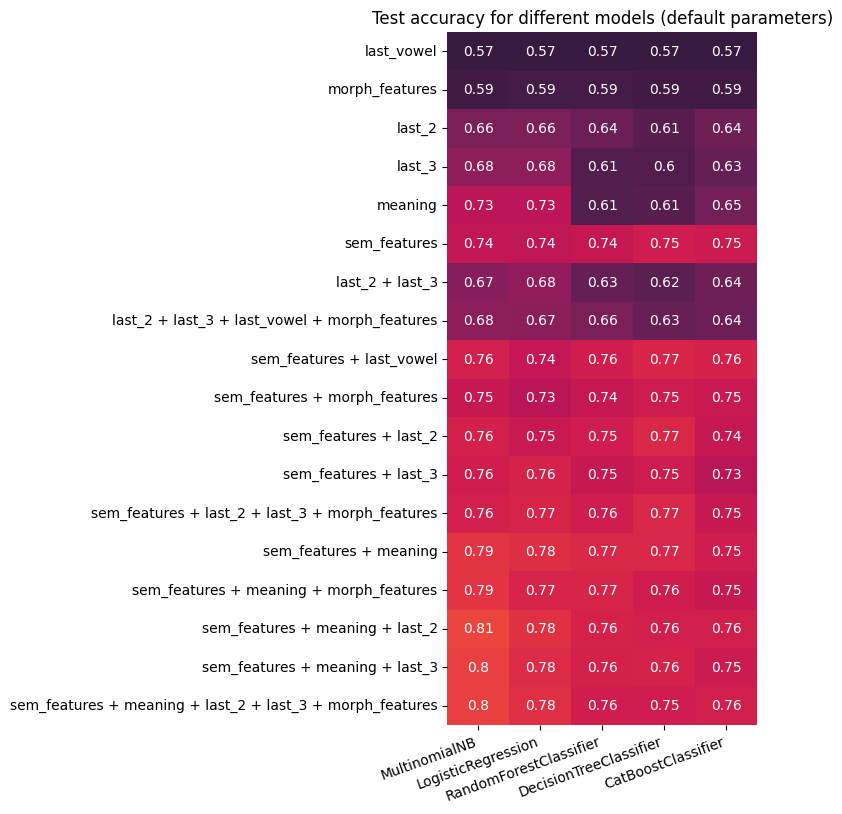

In [21]:
accuracies = {}
for key in results:
    accuracies[key] = show_accuracy(results[key])
accuracies = pd.DataFrame(accuracies).transpose()
#accuracies["mean"] = accuracies[accuracies.columns.values].mean(axis=1)
#accuracies = accuracies.sort_values(by="mean")

plt.figure(figsize=(4, 9))
sns.heatmap(accuracies, vmin=0.5, vmax=1, annot=True, cbar=False)
plt.title(f"Test accuracy for different models (default parameters)")
plt.xticks(rotation=20, ha="right")
plt.savefig(f"accuracy_test{SETTINGS['TEST_SIZE']}_default.png", bbox_inches='tight')
plt.show()

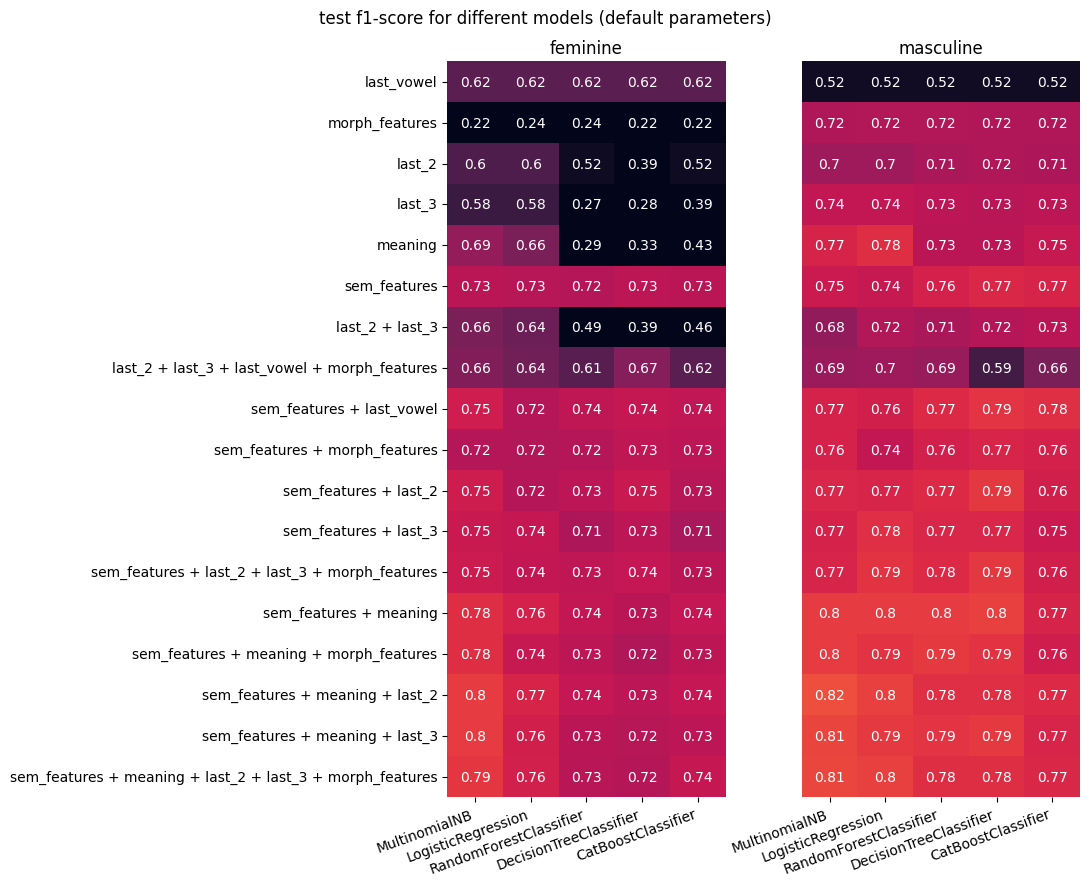

In [33]:
SCORE_NAME = "f1-score"

class_scores = {"f": {}, "m": {}}
for key in results:
    class_scores["f"][key], class_scores["m"][key] = {}, {}
    for model_ in show_class_score(results[key], SCORE_NAME).items():
        for class_ in ("m", "f"):
            class_scores[class_][key][f'{model_[0]}'] = model_[1][class_]

class_scores["f"], class_scores["m"] = pd.DataFrame(class_scores["f"]).transpose(), pd.DataFrame(class_scores["m"]).transpose()
#class_scores["mean"] = class_scores[class_scores.columns.values].mean(axis=1)
#class_scores = class_scores.sort_values(by="mean").drop("mean", axis=1)

fig, axes = plt.subplots(ncols=2, figsize=(11, 9))
ax1, ax2 = axes

sns.heatmap(class_scores["f"], vmin=0.5, vmax=1, annot=True, cbar=False, ax=ax1)
sns.heatmap(class_scores["m"], vmin=0.5, vmax=1, annot=True, cbar=False, yticklabels=False, ax=ax2)
ax1.set_title("feminine")
ax2.set_title("masculine")
for ax in [ax1, ax2]:
    plt.sca(ax)  # Set the current axis
    plt.xticks(rotation=20, ha="right")
fig.suptitle(f"test {SCORE_NAME} for different models (default parameters)")
fig.tight_layout()
plt.savefig(f"f1_test{SETTINGS['TEST_SIZE']}_default.png", bbox_inches='tight')
plt.show()

### Feature importances

In [23]:
show_importances(models["sem_features"]["rfc"], sem_features, 20)

,feature,importance
1,massabstr,0.400898
2,householdobjects,0.084993
3,animals,0.079776
4,indspec,0.072987
5,neg,0.044179
6,sex=f,0.036179
7,trees,0.035813
8,culturalprod.,0.031681
9,water,0.031492
10,sicknesses,0.023315


### DTC Tree

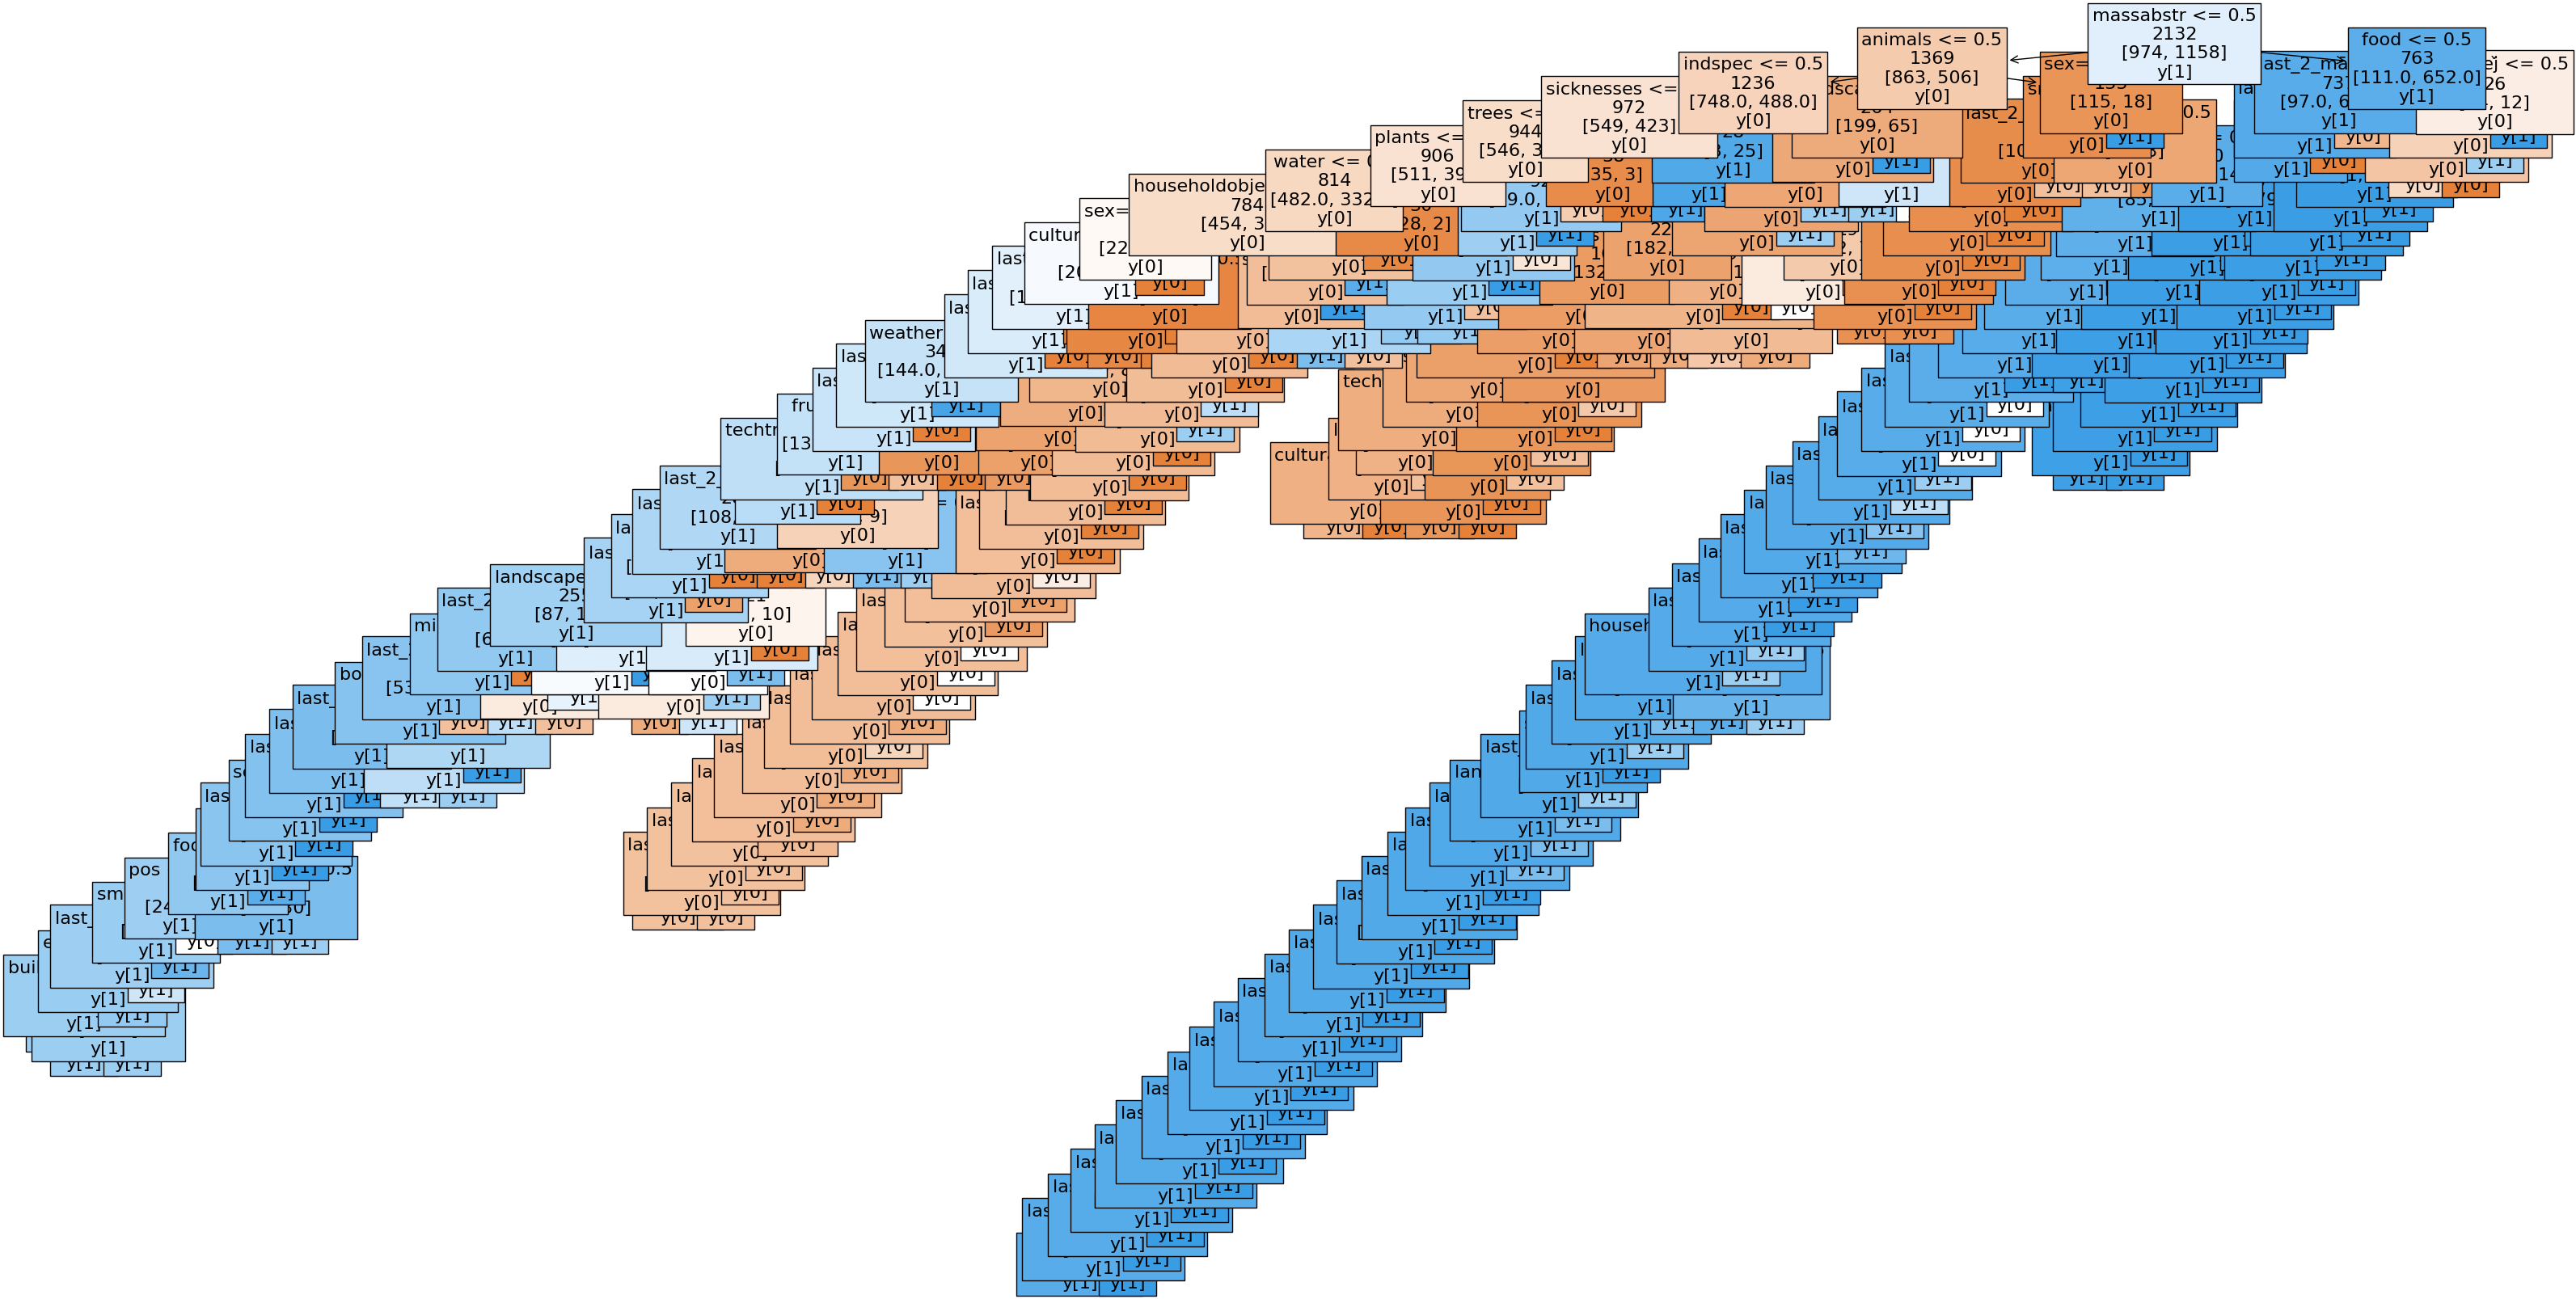

In [105]:
dtc_tree(models["sem_features + last_2"]["dtc"], sem_features+word_endings["last_2"].tolist())

### Predictions

In [24]:
predictions = {}
for feature in y_pred.keys():
    predictions[f"LR_{feature}"] = list(y_pred[feature]["LogisticRegression"])

test_indices = list(train_test_split(data["last_2"], data["meaning_gender"], test_size=SETTINGS["TEST_SIZE"],
                 random_state=SETTINGS["RANDOM_STATE"])[1].index)

predictions = pd.DataFrame(predictions, index=test_indices)
predictions = pd.merge(data, predictions, left_index=True, right_index=True)

for feature in y_pred.keys():
    predictions[f"LR_{feature}"] = np.where(predictions[f"LR_{feature}"] == predictions["meaning_gender"], "true", "false")

predictions.to_csv("res_predictions.csv")

#for feature in y_pred.keys():
#    predictions[f"LogReg_{feature}"] = np.where(predictions[f"LogReg_{feature}"] == "f", 1, 0)

In [25]:
predictions.columns

Index(['meaning_id', 'unit_id', 'full_entry', 'meaning', 'article_gender',
       'meaning_gender', 'gendered', 'comment', 'suffix', 'suffix_bVc',
       'suffix_ak', 'deverbal', 'infinitive', 'russian_borrowing', 'stress',
       'human', 'sex=f', 'sex=m', 'indspec', 'massabstr', 'large', 'small',
       'animals', 'water', 'trees', 'fruit', 'techtransport', 'culturalprod.',
       'name', 'householdobjects', 'food', 'drink', 'plants', 'events', 'pos',
       'neg', 'weather', 'bodyparts', 'buildings', 'landscape', 'milkprod.',
       'sicknesses', 'meanings_concatenated', 'meaning_with_examples',
       'label_id', 'forms_id', 'gloss_id', 'gloss', 'form', 'source', 'last_2',
       'last_3', 'last_4', 'last_vowel', 'LR_last_vowel', 'LR_morph_features',
       'LR_last_2', 'LR_last_3', 'LR_meaning', 'LR_sem_features',
       'LR_last_2 + last_3',
       'LR_last_2 + last_3 + last_vowel + morph_features',
       'LR_sem_features + last_vowel', 'LR_sem_features + morph_features',
      

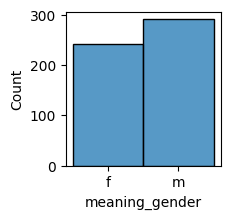

In [26]:
plt.figure(figsize=(2, 2))
sns.histplot(predictions["meaning_gender"])
plt.show()

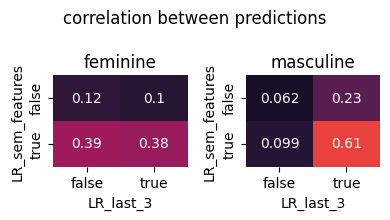

In [27]:
predictions_f = predictions[predictions["meaning_gender"] == "f"]
predictions_m = predictions[predictions["meaning_gender"] == "m"]

FEATURE_1, FEATURE_2 = "LR_sem_features", "LR_last_3"

fig, axes = plt.subplots(ncols=2, figsize=(4, 2.2))
ax1, ax2 = axes

sns.heatmap(pd.crosstab(predictions_f[FEATURE_1], predictions_f[FEATURE_2], normalize="all"),
            vmin=0, vmax=1, annot=True, cbar=False, ax=ax1)
sns.heatmap(pd.crosstab(predictions_m[FEATURE_1], predictions_m[FEATURE_2], normalize="all"),
            vmin=0, vmax=1, annot=True, cbar=False, ax=ax2)
ax1.set_title("feminine")
ax2.set_title("masculine")
fig.suptitle("correlation between predictions")
fig.tight_layout()
plt.show()